# thal2 1:1 Bifurcation Diagrams

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import get_phase, bif1d, follow_phase_diffs

from lib.rhs import _redu_c2,_full, _redu_full

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':-1,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [6]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [7]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [8]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    tot = 0
    for i in range(len(a.het_coeffs)):
        tot += eps**i*b**(i+1)*a.het_coeffs[i]
    a.system1.pardict['del0'] = tot
    print(a.system1.pardict['del0'])
    #print(pd1['del0'])
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [9]:
system1 = rsp(idx=0,model_name='thal0_85',**kws1)
system2 = rsp(idx=1,model_name='thal1_85',**kws1)

mkdir ./data/thal0_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9901981522494304
* Loading monodromy...
* Floquet Exponent kappa =-0.02435447459817712
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9901981522494304
* Loading monodromy...
* Floquet Exponent kappa =-0.02435447459817712
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 1:1

In [184]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',1),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,100], # [eps, eps^2, etc]
        }
a11 = nm.nmCoupling(**kw_nm)

Initializing 11 Coupling...
pfactor 30
G {'fname': './data/thal0_85/G_2_f=False.d', 'fname_psi': './data/thal0_85/G_psi_2_f=False.d', 'fname_gz': './data/thal0_85/gz_2_f=False.d', 'fname_gi': './data/thal0_85/gi_2_f=False.d', 'sym': {'v0': -del0*om0/c0 + eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_psi': {'v0': -del0*om0/c0 + esyn0*om0*om_fix0*ps1*gw1[1]/(100*c0) + esyn0*om0*om_fix0*w1/(100*c0) - 1.0*om0*om_fix0*ps0*ps1*gv0[1]*gw1[1]/c0 - om0*om_fix0*ps0*w1*gv0[1]/c0 - om0*om_fix0*ps1*v0*gw1[1]/c0 - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'vec': Matrix([
[eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om

### Plot 1par eps

<Axes: >

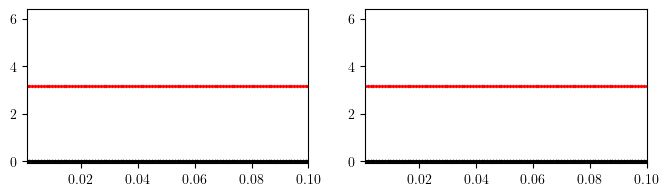

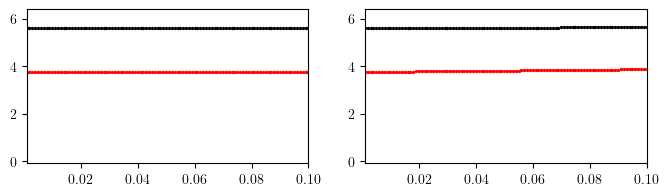

In [185]:
etup11 = (.001,.1,100)

fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a11,del1=0,eps_tup=etup11,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a11,del1=.01,eps_tup=etup11,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# for i in range(2):
#     draw_quick_plot_f(axs[i],data_b1_list,a11)

### Plot 1par del

<Axes: >

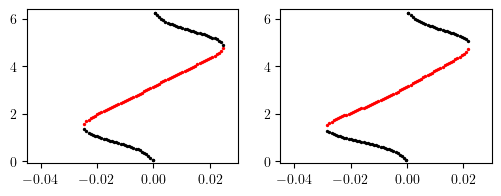

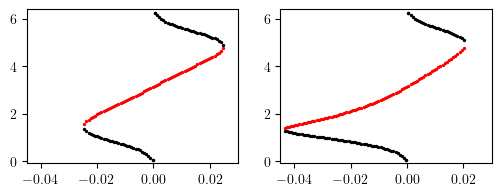

In [186]:
dtup11 = (-.045,.03,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a11,eps=0.05,del_tup=dtup11,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)


fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a11,eps=0.1,del_tup=dtup11,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)


#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a11)

### Sims and Plot

full sols_temp/sol_f_thal2_nm=11_eps=0.075_b=-0.05_T=2000_phi0=6.dat
redu sols_temp/sol_r_thal2_nm=11_eps=0.075_b=-0.05_T=2000_phi0=6.dat
-0.03125


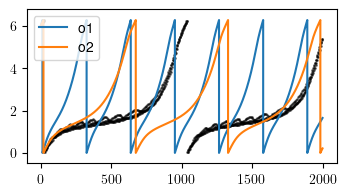

In [198]:
dat1,dat2=load_sol_all(a=a11,eps=0.075,phi0=6,b=-.05,T=2000,recompute=True)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

## b=0

In [14]:
b11a = 0

### Get Branches Full

In [15]:
# kw_p0 = {'a':a11,'del1':b11a,'recompute':False,'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [16]:
# data_b1_list = []

In [17]:
# in_dicts = [dict(phi0=0,eps_init=0.20,eps_final=0.1,deps=-.001), # bot
            
#             #dict(phi0=0,eps_init=0.042,eps_final=0.002,deps=-.002),
#            ]

In [18]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_p0)
#     data_b1_list.append(dat)
# fname = kw_p0['bifdir']+'hyper_thal2_11_b1.txt'

In [19]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname,hyp_inputs)

## b=0

In [20]:
b11b = 0

### Get Branches Full

In [21]:
# kw_p0 = {'a':a11,'del1':b11b,'recompute':False,'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [22]:
# data_b1_list = []

In [23]:
# in_dicts = [dict(phi0=0,eps_init=0.20,eps_final=0.1,deps=-.001), # bot
            
#             #dict(phi0=0,eps_init=0.042,eps_final=0.002,deps=-.002),
#            ]

In [24]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_p0)
#     data_b1_list.append(dat)
# fname = kw_p0['bifdir']+'hyper_thal2_11_b1.txt'

In [25]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname,hyp_inputs)

# Initialize Coupling 1:2

In [130]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',2),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
        'het_coeffs':[1,100]}
a12 = nm.nmCoupling(**kw_nm)

Initializing 12 Coupling...
pfactor 30
G {'fname': './data/thal0_85/G_2_f=False.d', 'fname_psi': './data/thal0_85/G_psi_2_f=False.d', 'fname_gz': './data/thal0_85/gz_2_f=False.d', 'fname_gi': './data/thal0_85/gi_2_f=False.d', 'sym': {'v0': -del0*om0/c0 + eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_psi': {'v0': -del0*om0/c0 + esyn0*om0*om_fix0*ps1*gw1[1]/(100*c0) + esyn0*om0*om_fix0*w1/(100*c0) - 1.0*om0*om_fix0*ps0*ps1*gv0[1]*gw1[1]/c0 - om0*om_fix0*ps0*w1*gv0[1]/c0 - om0*om_fix0*ps1*v0*gw1[1]/c0 - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'vec': Matrix([
[eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om

### Plot 1par eps

<Axes: >

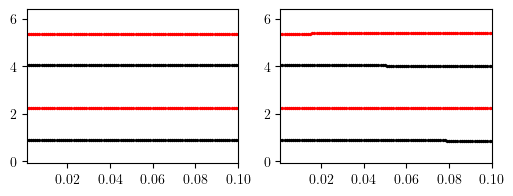

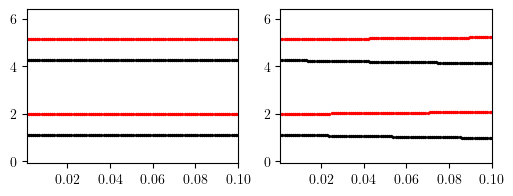

In [133]:
etup12 = (.001,.1,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a12,del1=-.01,eps_tup=etup12,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a12,del1=-0.02,eps_tup=etup12,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# for i in range(4):
#     draw_quick_plot_f(axs[i],data_b1_list,a12)

### Plot 1par del

<Axes: >

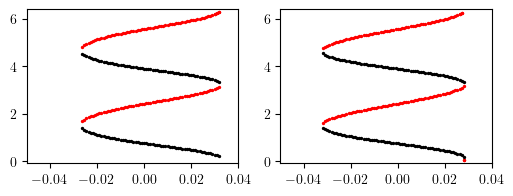

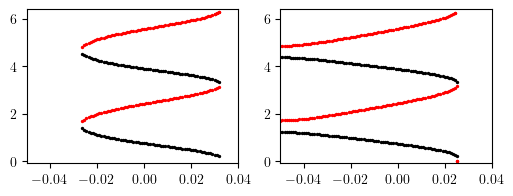

In [132]:
dtup12 = (-.05,.04,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a12,eps=0.05,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a12,eps=0.1,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a11)

## Plot 2par

In [148]:
# start raw code here for now, organize later.

### Sims and Plot

full sols_temp/sol_f_thal2_nm=12_eps=0.1_b=-0.04_T=1000_phi0=6.dat
redu sols_temp/sol_r_thal2_nm=12_eps=0.1_b=-0.04_T=1000_phi0=6.dat
-0.024


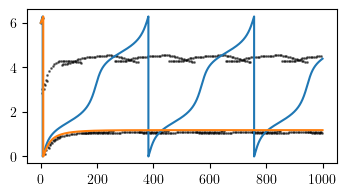

In [29]:
dat1,dat2=load_sol_all(a=a12,eps=0.1,phi0=6,b=-.04,T=1000,recompute=True)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

# Initialize Coupling 2:1

In [134]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',2),'_m':('om1',1),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
        'het_coeffs':[1,100]}
a21 = nm.nmCoupling(**kw_nm)

Initializing 21 Coupling...
pfactor 30
G {'fname': './data/thal0_85/G_2_f=False.d', 'fname_psi': './data/thal0_85/G_psi_2_f=False.d', 'fname_gz': './data/thal0_85/gz_2_f=False.d', 'fname_gi': './data/thal0_85/gi_2_f=False.d', 'sym': {'v0': -del0*om0/c0 + eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_psi': {'v0': -del0*om0/c0 + esyn0*om0*om_fix0*ps1*gw1[1]/(100*c0) + esyn0*om0*om_fix0*w1/(100*c0) - 1.0*om0*om_fix0*ps0*ps1*gv0[1]*gw1[1]/c0 - om0*om_fix0*ps0*w1*gv0[1]/c0 - om0*om_fix0*ps1*v0*gw1[1]/c0 - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'vec': Matrix([
[eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om

### Plot 1par eps

<Axes: >

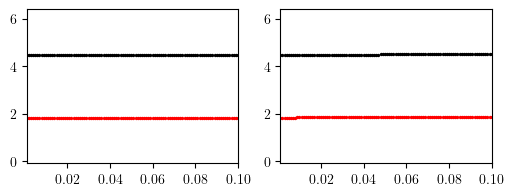

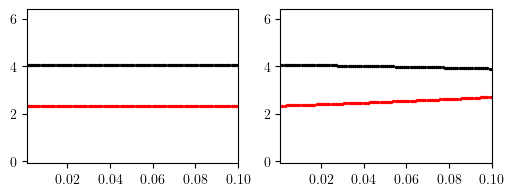

In [135]:
etup21 = (.001,.1,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a21,del1=0.01,eps_tup=etup21,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a21,del1=0.02,eps_tup=etup21,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

<Axes: >

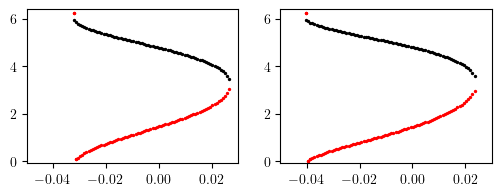

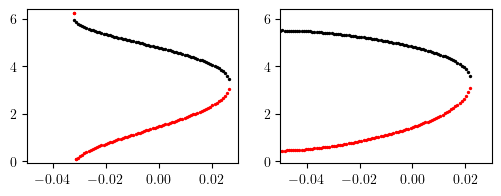

In [136]:
dtup21 = (-.05,.03,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a21,eps=0.05,del_tup=dtup21,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a21,eps=0.1,del_tup=dtup21,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)


#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a11)

### Sims and Plot

full sols_temp/sol_f_thal2_nm=21_eps=0.1_b=0.027_T=2000_phi0=6.dat
redu sols_temp/sol_r_thal2_nm=21_eps=0.1_b=0.027_T=2000_phi0=6.dat
0.03429


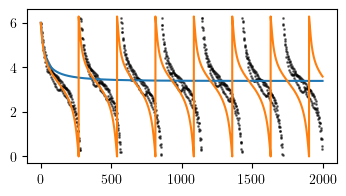

In [33]:
dat1,dat2=load_sol_all(a=a21,eps=0.1,phi0=6,b=.027,T=2000,recompute=True)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

# Initialize Coupling 2:3

In [149]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',2),'_m':('om1',3),
         'NH':1024,'save_fig':False,'recompute_list':recompute_list,
        'het_coeffs':[1,2000]}
a23 = nm.nmCoupling(**kw_nm)

Initializing 23 Coupling...
pfactor 30
G {'fname': './data/thal0_85/G_2_f=False.d', 'fname_psi': './data/thal0_85/G_psi_2_f=False.d', 'fname_gz': './data/thal0_85/gz_2_f=False.d', 'fname_gi': './data/thal0_85/gi_2_f=False.d', 'sym': {'v0': -del0*om0/c0 + eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_psi': {'v0': -del0*om0/c0 + esyn0*om0*om_fix0*ps1*gw1[1]/(100*c0) + esyn0*om0*om_fix0*w1/(100*c0) - 1.0*om0*om_fix0*ps0*ps1*gv0[1]*gw1[1]/c0 - om0*om_fix0*ps0*w1*gv0[1]/c0 - om0*om_fix0*ps1*v0*gw1[1]/c0 - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'vec': Matrix([
[eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om

### Plot 1par eps

<Axes: >

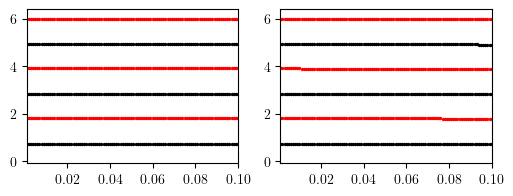

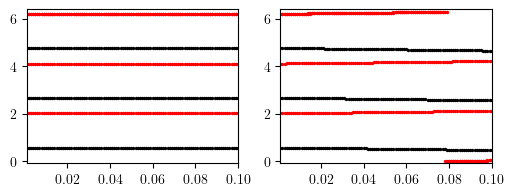

In [150]:
etup23 = (.001,.1,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a23,del1=0,eps_tup=etup23,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a23,del1=0.0025,eps_tup=etup23,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)


# for i in range(4):
#     draw_quick_plot_f(axs[i],data_b1_list,a12)

### Plot 1par del

<Axes: >

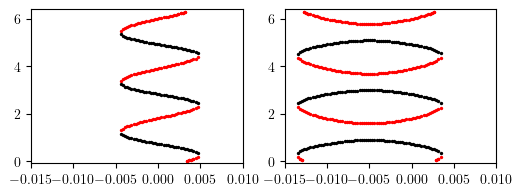

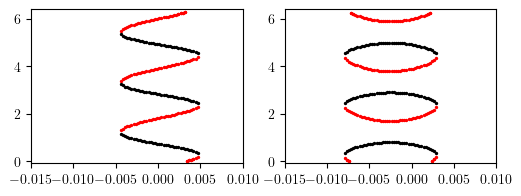

In [151]:
dtup23 = (-.015,.01,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a23,eps=0.05,del_tup=dtup23,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a23,eps=0.1,del_tup=dtup23,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a11)

### Sims and Plot

full sols_temp/sol_f_thal2_nm=23_eps=0.1_b=-0.005_T=2000_phi0=0.dat
redu sols_temp/sol_r_thal2_nm=23_eps=0.1_b=-0.005_T=2000_phi0=0.dat
0.0


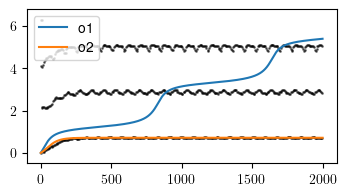

In [152]:
dat1,dat2=load_sol_all(a=a23,eps=0.1,phi0=0,b=-.005,T=2000,recompute=True)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

# Initialize Coupling 3:2

In [170]:
recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
#recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',3),'_m':('om1',2),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
        'het_coeffs':[1,2000]}
a32 = nm.nmCoupling(**kw_nm)

Initializing 32 Coupling...
pfactor 30
* Computing G symbolic...
* Computing G symbolic...
G {'fname': './data/thal0_85/G_2_f=False.d', 'fname_psi': './data/thal0_85/G_psi_2_f=False.d', 'fname_gz': './data/thal0_85/gz_2_f=False.d', 'fname_gi': './data/thal0_85/gi_2_f=False.d', 'sym': {'v0': -del0*om0/c0 + eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_psi': {'v0': -del0*om0/c0 + esyn0*om0*om_fix0*ps1*gw1[1]/(100*c0) + esyn0*om0*om_fix0*w1/(100*c0) - 1.0*om0*om_fix0*ps0*ps1*gv0[1]*gw1[1]/c0 - om0*om_fix0*ps0*w1*gv0[1]/c0 - om0*om_fix0*ps1*v0*gw1[1]/c0 - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_fn': [-om0*om_fix0*(100*del0/om_fix0 + w1*(-esyn0 + 100*v0))/(100*c0), 0, 0, 0], 'vec': Matrix([
[eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om

### Plot 1par eps

<Axes: >

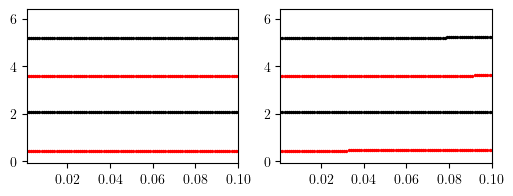

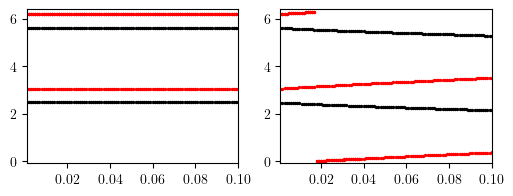

In [171]:
etup32 = (.001,.1,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a32,del1=0,eps_tup=etup32,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a32,del1=-.004,eps_tup=etup32,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# for i in range(4):
#     draw_quick_plot_f(axs[i],data_b1_list,a12)

### Plot 1par del

<Axes: >

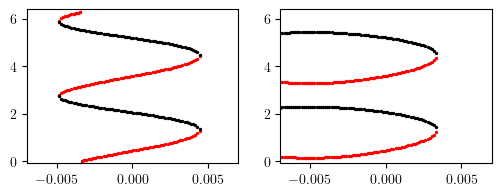

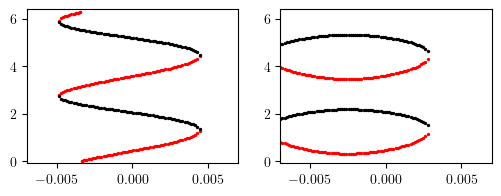

In [172]:
dtup32 = (-.007,.007,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a32,eps=0.05,del_tup=dtup32,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a32,eps=0.1,del_tup=dtup32,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a11)

### Sims and Plot

full sols_temp/sol_f_thal2_nm=32_eps=0.05_b=-0.006_T=2000_phi0=2.dat
redu sols_temp/sol_r_thal2_nm=32_eps=0.05_b=-0.006_T=2000_phi0=2.dat
-0.0024


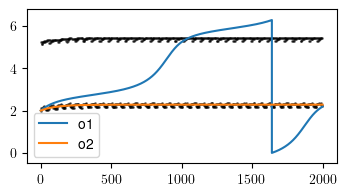

In [173]:
dat1,dat2=load_sol_all(a=a32,eps=0.05,phi0=2,b=-0.006,T=2000,recompute=True)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

In [162]:
a32.het_coeffs

[1, 500]

# Initialize Coupling 1:3

In [78]:
recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
#recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',3),
         'NH':1024,'save_fig':False,'recompute_list':recompute_list,
        'het_coeffs':[1,100]}
a13 = nm.nmCoupling(**kw_nm)

Initializing 13 Coupling...
pfactor 30
* Computing G symbolic...
* Computing G symbolic...
G {'fname': './data/thal0_85/G_2_f=False.d', 'fname_psi': './data/thal0_85/G_psi_2_f=False.d', 'fname_gz': './data/thal0_85/gz_2_f=False.d', 'fname_gi': './data/thal0_85/gi_2_f=False.d', 'sym': {'v0': -del0*om0/c0 + eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_psi': {'v0': -del0*om0/c0 + esyn0*om0*om_fix0*ps1*gw1[1]/(100*c0) + esyn0*om0*om_fix0*w1/(100*c0) - 1.0*om0*om_fix0*ps0*ps1*gv0[1]*gw1[1]/c0 - om0*om_fix0*ps0*w1*gv0[1]/c0 - om0*om_fix0*ps1*v0*gw1[1]/c0 - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_fn': [-om0*om_fix0*(100*del0/om_fix0 + w1*(-esyn0 + 100*v0))/(100*c0), 0, 0, 0], 'vec': Matrix([
[eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om

### Plot 1par eps

<Axes: >

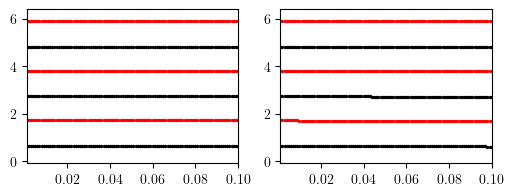

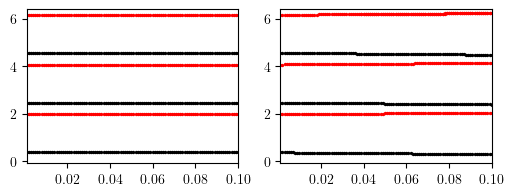

In [139]:
etup13 = (.001,.1,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a13,del1=0,eps_tup=etup13,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a13,del1=0.02,eps_tup=etup13,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)


# for i in range(4):
#     draw_quick_plot_f(axs[i],data_b1_list,a12)

### Plot 1par del

<Axes: >

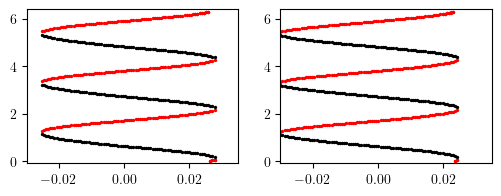

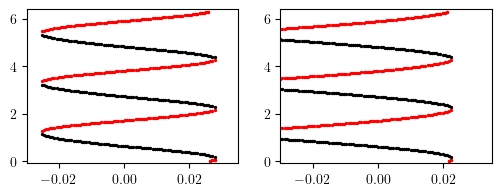

In [140]:
dtup13 = (-.03,.035,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a13,eps=0.05,del_tup=dtup13,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)


fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a13,eps=0.1,del_tup=dtup13,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)


#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a11)

### Sims and Plot

full sols_temp/sol_f_thal2_nm=13_eps=0.1_b=0.025_T=2000_phi0=6.dat
redu sols_temp/sol_r_thal2_nm=13_eps=0.1_b=0.025_T=2000_phi0=6.dat
0.03125


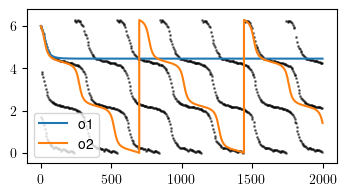

In [84]:
dat1,dat2=load_sol_all(a=a13,eps=0.1,phi0=6,b=.025,T=2000,recompute=True)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

# Initialize Coupling 3:1

In [93]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',3),'_m':('om1',1),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
        'het_coeffs':[1,200]}
a31 = nm.nmCoupling(**kw_nm)

Initializing 31 Coupling...
pfactor 30
G {'fname': './data/thal0_85/G_2_f=False.d', 'fname_psi': './data/thal0_85/G_psi_2_f=False.d', 'fname_gz': './data/thal0_85/gz_2_f=False.d', 'fname_gi': './data/thal0_85/gi_2_f=False.d', 'sym': {'v0': -del0*om0/c0 + eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_psi': {'v0': -del0*om0/c0 + esyn0*om0*om_fix0*ps1*gw1[1]/(100*c0) + esyn0*om0*om_fix0*w1/(100*c0) - 1.0*om0*om_fix0*ps0*ps1*gv0[1]*gw1[1]/c0 - om0*om_fix0*ps0*w1*gv0[1]/c0 - om0*om_fix0*ps1*v0*gw1[1]/c0 - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'vec': Matrix([
[eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om

### Plot 1par eps

<Axes: >

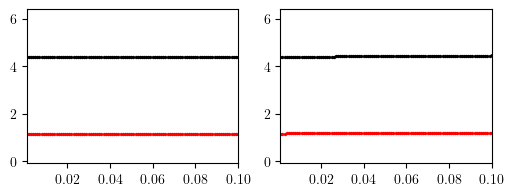

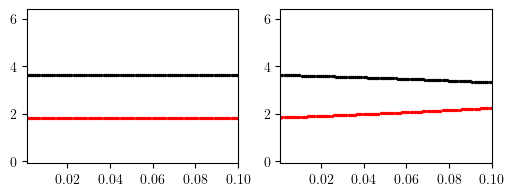

In [143]:
etup31 = (.001,.1,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a31,del1=0,eps_tup=etup31,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)


fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a31,del1=0.017,eps_tup=etup31,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)


# for i in range(4):
#     draw_quick_plot_f(axs[i],data_b1_list,a12)

### Plot 1par del

<Axes: >

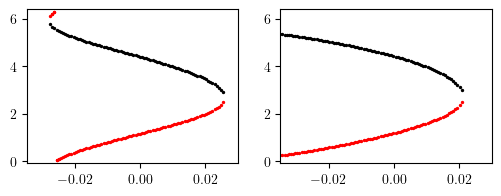

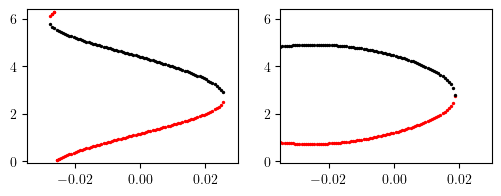

In [142]:
dtup31 = (-.035,.03,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a31,eps=0.05,del_tup=dtup31,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a31,eps=0.1,del_tup=dtup31,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)


#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a11)

### Sims and Plot

full sols_temp/sol_f_thal2_nm=31_eps=0.1_b=0.02_T=2000_phi0=6.dat
redu sols_temp/sol_r_thal2_nm=31_eps=0.1_b=0.02_T=2000_phi0=6.dat
0.028


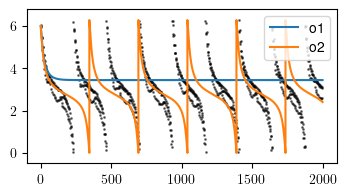

In [97]:
dat1,dat2=load_sol_all(a=a31,eps=0.1,phi0=6,b=.02,T=2000,recompute=True)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

# Initialize Coupling 3:4

In [199]:
recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',3),'_m':('om1',4),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
        'het_coeffs':[1,1000]}
a34 = nm.nmCoupling(**kw_nm)

Initializing 34 Coupling...
pfactor 30
G {'fname': './data/thal0_85/G_2_f=False.d', 'fname_psi': './data/thal0_85/G_psi_2_f=False.d', 'fname_gz': './data/thal0_85/gz_2_f=False.d', 'fname_gi': './data/thal0_85/gi_2_f=False.d', 'sym': {'v0': -del0*om0/c0 + eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_psi': {'v0': -del0*om0/c0 + esyn0*om0*om_fix0*ps1*gw1[1]/(100*c0) + esyn0*om0*om_fix0*w1/(100*c0) - 1.0*om0*om_fix0*ps0*ps1*gv0[1]*gw1[1]/c0 - om0*om_fix0*ps0*w1*gv0[1]/c0 - om0*om_fix0*ps1*v0*gw1[1]/c0 - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'vec': Matrix([
[eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om

### Plot 1par eps

<Axes: >

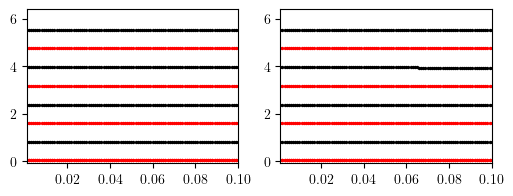

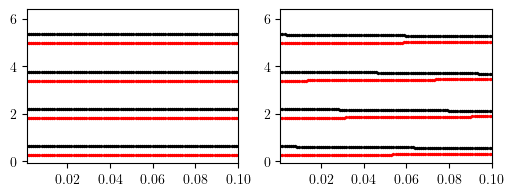

In [200]:
etup34 = (.001,.1,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a34,del1=0,eps_tup=etup34,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a34,del1=.0015,eps_tup=etup34,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# for i in range(4):
#     draw_quick_plot_f(axs[i],data_b1_list,a12)

### Plot 1par del

<Axes: >

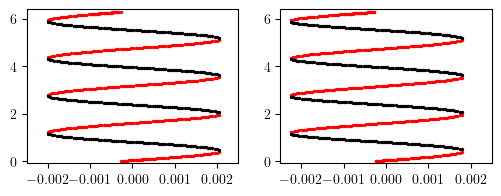

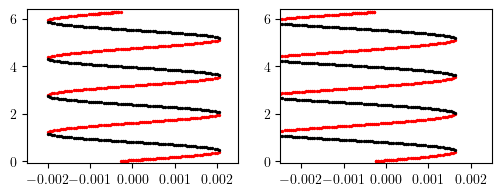

In [201]:
dtup34 = (-.0025,.0025,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a34,eps=0.05,del_tup=dtup34,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a34,eps=0.1,del_tup=dtup34,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a11)

### Sims and Plot

full sols_temp/sol_f_thal2_nm=34_eps=0.1_b=0_T=2000_phi0=6.dat
redu sols_temp/sol_r_thal2_nm=34_eps=0.1_b=0_T=2000_phi0=6.dat
0.0


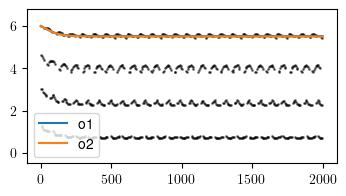

In [202]:
dat1,dat2=load_sol_all(a=a34,eps=0.1,phi0=6,b=0,T=2000,recompute=True)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

full sols_temp/sol_f_thal2_nm=34_eps=0.1_b=-0.005_T=2000_phi0=6.dat
redu sols_temp/sol_r_thal2_nm=34_eps=0.1_b=-0.005_T=2000_phi0=6.dat
-0.0025


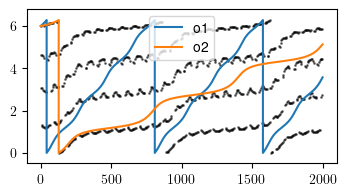

In [182]:
dat1,dat2=load_sol_all(a=a34,eps=0.1,phi0=6,b=-.005,T=2000,recompute=True)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

full sols_temp/sol_f_thal2_nm=34_eps=0.1_b=-0.01_T=2000_phi0=6.dat
redu sols_temp/sol_r_thal2_nm=34_eps=0.1_b=-0.01_T=2000_phi0=6.dat
0.0


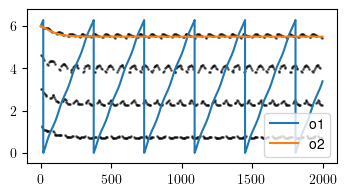

In [183]:
dat1,dat2=load_sol_all(a=a34,eps=0.1,phi0=6,b=-.01,T=2000,recompute=True)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

# Initialize Coupling 4:3

In [114]:
recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
#recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',4),'_m':('om1',3),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
        'het_coeffs':[1,1000]}
a43 = nm.nmCoupling(**kw_nm)

Initializing 43 Coupling...
pfactor 30
* Computing G symbolic...
* Computing G symbolic...
G {'fname': './data/thal0_85/G_2_f=False.d', 'fname_psi': './data/thal0_85/G_psi_2_f=False.d', 'fname_gz': './data/thal0_85/gz_2_f=False.d', 'fname_gi': './data/thal0_85/gi_2_f=False.d', 'sym': {'v0': -del0*om0/c0 + eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om_fix0*v0*g_thal1_85_w1[1]*p_thal1_85[1]/c0 - eps*om0*om_fix0*w1*g_thal0_85_v0[1]*p_thal0_85[1]/c0 + esyn0*om0*om_fix0*w1/(100*c0) - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_psi': {'v0': -del0*om0/c0 + esyn0*om0*om_fix0*ps1*gw1[1]/(100*c0) + esyn0*om0*om_fix0*w1/(100*c0) - 1.0*om0*om_fix0*ps0*ps1*gv0[1]*gw1[1]/c0 - om0*om_fix0*ps0*w1*gv0[1]/c0 - om0*om_fix0*ps1*v0*gw1[1]/c0 - om0*om_fix0*v0*w1/c0, 'h0': 0, 'r0': 0, 'w0': 0}, 'sym_fn': [-om0*om_fix0*(100*del0/om_fix0 + w1*(-esyn0 + 100*v0))/(100*c0), 0, 0, 0], 'vec': Matrix([
[eps*esyn0*om0*om_fix0*g_thal1_85_w1[1]*p_thal1_85[1]/(100*c0) - eps*om0*om

### Plot 1par eps

<Axes: >

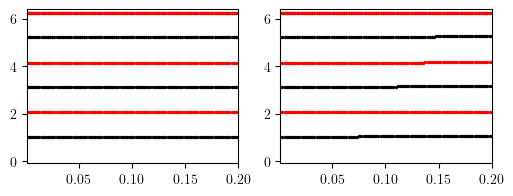

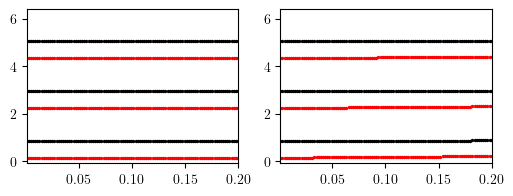

In [146]:
etup43 = (.001,.2,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a43,del1=0,eps_tup=etup43,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a43,del1=0.001,eps_tup=etup43,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)


# for i in range(4):
#     draw_quick_plot_f(axs[i],data_b1_list,a12)

### Plot 1par del

<Axes: >

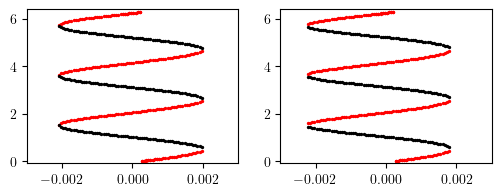

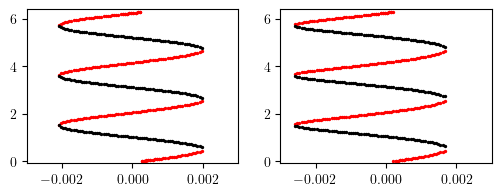

In [147]:
dtup43 = (-.003,.003,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a43,eps=0.05,del_tup=dtup43,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a43,eps=0.1,del_tup=dtup43,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)


#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a11)

### Sims and Plot

full sols_temp/sol_f_thal2_nm=43_eps=0.2_b=0.0019_T=2000_phi0=6.dat
redu sols_temp/sol_r_thal2_nm=43_eps=0.2_b=0.0019_T=2000_phi0=6.dat
0.002622


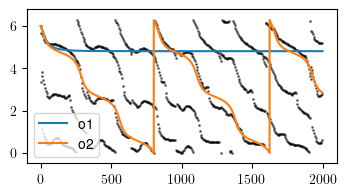

In [117]:
dat1,dat2=load_sol_all(a=a43,eps=0.2,phi0=6,b=.0019,T=2000,recompute=True)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()